Dependencies
===============

In [34]:
from __future__ import division

from IPython.display import *

from numpy import *; seterr(all="ignore")
from numpy import linalg
from numpy import random

%matplotlib notebook
from matplotlib.pyplot import *

import wish

import audio.wave as wave
from audio.filters import FIR, AR
import audio.frames
import audio.index
from audio.lp import lp
from audio.quantizers import Quantizer

In [35]:
df = 16000
dt = 1.0 / df

Sandbox
========

FIR
---

In [36]:
fir = FIR([1.0])
print fir(2.0)
print fir(1.0)
print fir([0.0, 7.0, -3.0])
delay = FIR([0.0, 1.0])
fir = delay
print fir(2.0)
print fir(1.0)
print fir([0.0, 7.0, -3.0])
print fir.a

2.0
1.0
[ 0.  7. -3.]
0.0
2.0
[1. 0. 7.]
[0. 1.]


Audio Sources
=============

Record Sound
-------------

In [4]:
#data = audio.io.record(3.0, df=df)[0]
#audio.io.play(data, df=df)

Phones (NLTK)
--------------------

In [37]:
aes = audio.index.search("ae", type=audio.index.Phone)
print aes
data = aes[0].audio

    0. ae (had [hv-ae-dcl]).
    1. ae (ask [ae-s]).
    2. ae (rag [r-ae-gcl]).
    3. ae (that [dh-ae-tcl]).
    4. ae (platform [pcl-p-l-ae-tcl-f-ao-m]).
    5. ae (ran [r-ae-nx]).
    6. ae (black [bcl-b-l-ae-kcl]).
    7. ae (man [m-ae-n]).
    8. ae (manufacturer [m-eh-n-y-ix-f-ae-kcl-sh-er-ax]).
    9. ae (clasp [k-l-ae-s-pcl-p]).
   10. ae (hand [hh-ae-n-dcl-d]).
   11. ae (autographs [ao-dx-ix-gcl-g-r-ae-f-s]).
   12. ae (had [hv-ae-dcl-jh]).
   13. ae (ask [ae-s]).
   14. ae (rag [r-ae-gcl-g]).
   15. ae (that [dh-ae-q]).
   16. ae (answered [ae-n-s-ix-dcl-d]).
   17. ae (hand [hh-ae-n]).
   18. ae (glass [gcl-g-l-ae-s]).
   19. ae (muskrat [m-ah-s-kcl-k-r-ae-tcl]).
   20. ae (tadpole [tcl-t-ae-dcl-p-ow-l]).
   21. ae (giraffes [jh-axr-ae-s]).
   22. ae (ask [ae-s-kcl]).
   23. ae (rag [r-ae-gcl-g]).
   24. ae (that [dh-ae-tcl-t]).
   25. ae (example [ix-gcl-z-ae-m-pcl-p-uh-l]).
   26. ae (packing [pcl-p-ae-kcl-k-iy-ng]).
   27. ae (and [q-ae-n-dcl-d]).
   28. ae (hand [hv-ae

you [y-ix]


<IPython.core.display.Javascript object>


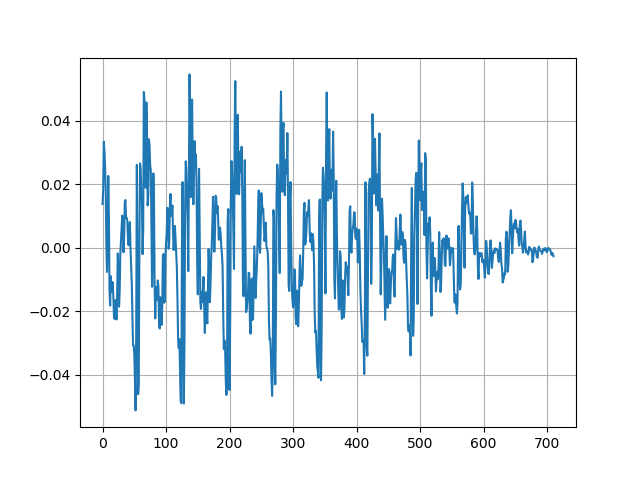

In [25]:
you = audio.index.search("you", type=audio.index.Word)[0]
print you
ixs = audio.index.search("ix")
data = ixs[0].audio
fig, axes = subplots()
axes.plot(data)
axes.axis("tight")
axes.grid()

In [7]:
sentence = audio.index.search(type=audio.index.Utterance)[0]
for word in sentence:
    print word
    for phone in word:
        print 4*" ", phone
data = sentence.audio
print data

h# (a crab challenged me but a quick stab vanquished him).
a [q-ey]
     q (a [q-ey]).
     ey (a [q-ey]).
crab [kcl-k-r-ae-bcl]
     kcl (crab [kcl-k-r-ae-bcl]).
     k (crab [kcl-k-r-ae-bcl]).
     r (crab [kcl-k-r-ae-bcl]).
     ae (crab [kcl-k-r-ae-bcl]).
     bcl (crab [kcl-k-r-ae-bcl]).
challenged [ch-ae-l-ax-n-dcl-jh-dcl-d]
     ch (challenged [ch-ae-l-ax-n-dcl-jh-dcl-d]).
     ae (challenged [ch-ae-l-ax-n-dcl-jh-dcl-d]).
     l (challenged [ch-ae-l-ax-n-dcl-jh-dcl-d]).
     ax (challenged [ch-ae-l-ax-n-dcl-jh-dcl-d]).
     n (challenged [ch-ae-l-ax-n-dcl-jh-dcl-d]).
     dcl (challenged [ch-ae-l-ax-n-dcl-jh-dcl-d]).
     jh (challenged [ch-ae-l-ax-n-dcl-jh-dcl-d]).
     dcl (challenged [ch-ae-l-ax-n-dcl-jh-dcl-d]).
     d (challenged [ch-ae-l-ax-n-dcl-jh-dcl-d]).
epi (a crab challenged me but a quick stab vanquished him).
me [m-iy]
     m (me [m-iy]).
     iy (me [m-iy]).
pau (a crab challenged me but a quick stab vanquished him).
but [b-eh-dx]
     b (but [b-eh-dx]).
     eh (

Sentence (NLTK)
--------------------

In [145]:
utterances = audio.index.search(type=audio.index.Utterance)
utterance = utterances[1]
display(utterance)
data = utterance.audio
audio.wave.write(data, "voice.wav", df=16000)
Audio("voice.wav")

a screwdriver is made from vodka and orange juice

Short-Term Prediction
======================

In [146]:
class STP(Quantizer):
    "Short-Term Predictor"
    def __init__(self, order=16, method="autocorrelation"):
        self.fir = FIR(a=r_[1.0, zeros(order)]) 
        self.ar  = AR(a=zeros(order))
        self.order = order
        self.method = method
    def encode(self, data):
        if self.method == "covariance" and self.order >= len(data):
            raise ValueError("not enough data samples")
        a = lp(data, order=self.order, method=self.method)
        self.fir.a[:] = r_[1.0, -a]
        error = self.fir(data)
        return (a, error) 
    def decode(self, data):
        a, error = data
        self.ar.a[:] = a
        return self.ar(error)

In [147]:
def stp_error(data, T=0.02, order=16, method="autocorrelation"):
    length = len(data)
    n = int(T * df) # number of samples for T s at the given frequency.
    frames = audio.frames.split(data, n, pad=True)
    stp = STP(order=order, method=method)
    error = zeros(n*len(frames))
    for i, frame in enumerate(frames):
        a, error_frame = stp.encode(frame)
        error[i*n:(i+1)*n] = error_frame
    return error[:length]

<IPython.core.display.Javascript object>


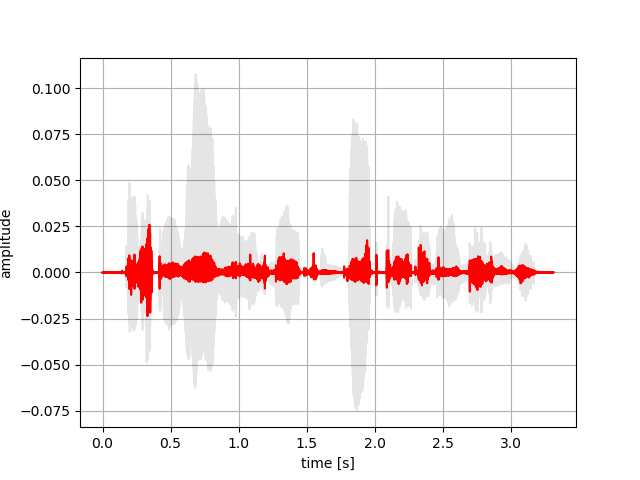

In [148]:
figure()    
n = len(data)
t = r_[0:n] / df
plot(t,data, "k", alpha=0.1); axis("tight")
error = stp_error(data)
plot(t,error, "r")
xlabel("time [s]")
ylabel("amplitude")
axis("tight")
grid()

SNR 17.235845897554015 dB


<IPython.core.display.Javascript object>


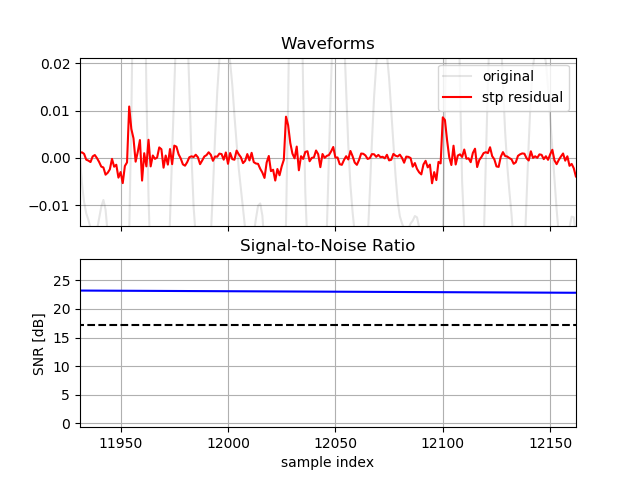

In [149]:
error = stp_error(data)
SNR2 = mean(data*data) / mean(error*error)
print "SNR", 10*log10(SNR2), "dB"

T = 20.0 / 1000 # 20 ms
n = int(df * T)
data_frames = audio.frames.split(data, n, pad=True)
error_frames = audio.frames.split(error, n, pad=True)

fig, (ax1, ax2) = subplots(2,1, sharex=True)
SNRs = [10.0 * log10(mean(d*d) / mean(e*e)) for d,e in zip(data_frames, error_frames)]
ax1.plot(data, "k", alpha=0.1, label="original")
ax1.plot(error, "r", label="stp residual")
ax1.set_title("Waveforms")
ax1.axis("tight")
ax1.legend()
ax1.grid()
ax2.plot(r_[0:len(SNRs)] * n,  SNRs, "b")
ax2.plot([0,len(data_frames)*n], [10*log10(SNR2), 10*log10(SNR2)], "k--")
ax2.set_xlabel("sample index")
ax2.set_ylabel("SNR [dB]")
ax2.set_title("Signal-to-Noise Ratio")
ax2.grid()

In [150]:
wave.write(error, "voice-error-stp.wav", df=df)
display(Audio("voice.wav"))
display(Audio("voice-error-stp.wav"))

Pitch Estimation
==========

In [128]:
# TODO: make criteria configurable, with argmax a default

def ltp_parameters(history, frame,
                   offset_min=1, offset_max=None,
                   gain_min=0.0, gain_max=inf,
                   SNR_min=1.0, SNR_max=inf,
                   select=argmax,
                   returns="offset, gain"):
    p = len(history)
    data = r_[history, frame] # full data
    m = len(frame)
    n = len(data)
    nxcorrs = zeros(p+1)
    gains = zeros(p+1)
    SNRs = zeros(p+1)
    valids = zeros(p+1, dtype=bool)
    frame_norm = linalg.norm(frame)
    normed_frame = frame / frame_norm
    for i in range(p + 1):
        windowed_data = data[n-i-m:n-i]
        windowed_data_norm = linalg.norm(windowed_data)
        normed_windowed_data = windowed_data / windowed_data_norm
        nxcorr = nxcorrs[i] = dot(normed_frame, normed_windowed_data)
        SNR = SNRs[i] = 1.0 / sqrt(1 - nxcorr*nxcorr)
        #print ">", SNR
        gain = gains[i] = nxcorr / windowed_data_norm * frame_norm
        valid = True
        if offset_min is not None:
            valid = valid and (offset_min <= i)
        if offset_max is not None:
            valid = valid and (i <= offset_max)
        valid = valid and (gain_min <= gain <= gain_max)
        valid = valid and (SNR_min <= SNR <= SNR_max)
        valids[i] = valid

    criteria = SNRs.copy() 
    criteria[logical_not(valids)] = -inf
    offset = select(criteria)
    if not valids[offset]: # everything is invalid!
        raise ValueError("no valid set of parameters")
    else:
        gain = gains[offset]
        nxcorr = nxcorrs[offset]
        SNR = SNRs[offset]

    return wish.grant(returns)

offset: 25 gain: 1.0294905014596782


<IPython.core.display.Javascript object>


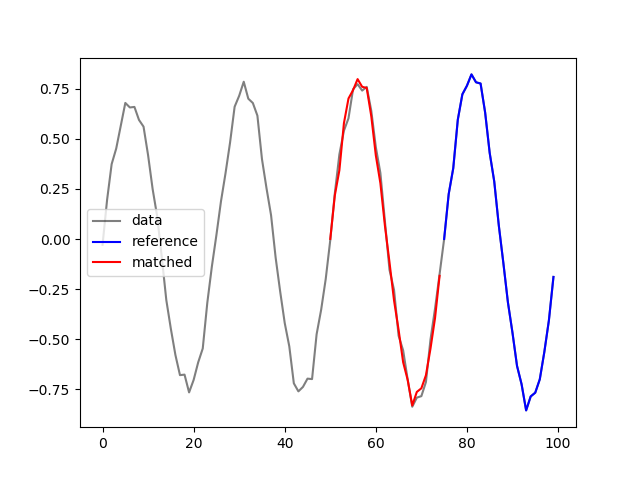

In [151]:
N = 100
data_ = (0.7 * sin(r_[0:N]/N * 2*pi*4) + 0.05 * random.uniform(-1,1,N)) * (1.0 + 0.2*r_[0:1:1.0/N])
#history[::7] = 1.0
history, frame = data_[:-25], data_[-25:]
m = len(history)
n = len(frame)
offset_min = 5
def select(factor):
    def _select(SNRs):
        i = argmax(SNRs)
        is_ = r_[0:len(SNRs)]
        SNRi = max(SNRs)
        js = [int(ceil(i/2.0)), int(floor(i/2.0)), int(ceil(i/3.0)), int(floor(i/3.0)), int(ceil(i/4.0)), int(floor(i/4.0))]
        ij = argmax(SNRs[js])
        #print(SNRi)
        #print(SNRs[js])
        #print js[ij]
        if SNRs[js[ij]] >= factor * SNRi:
            return js[ij]
        else:
            return i
    return _select
offset, gain, nxcorrs, SNRs, valids = ltp_parameters(history, frame, offset_min=offset_min, SNR_min=1.0, select=select(0.5),
                                                     returns="offset, gain, nxcorrs, SNRs, valids")
print "offset:", offset, "gain:", gain

figure()
plot(data_, "k", alpha=0.5, label="data")
plot(arange(0,n)+m, frame, "b", label="reference")
plot(arange(m-offset, m-offset+n), frame/gain, "r", label="matched")
axis("tight")
legend(loc=0)

<IPython.core.display.Javascript object>


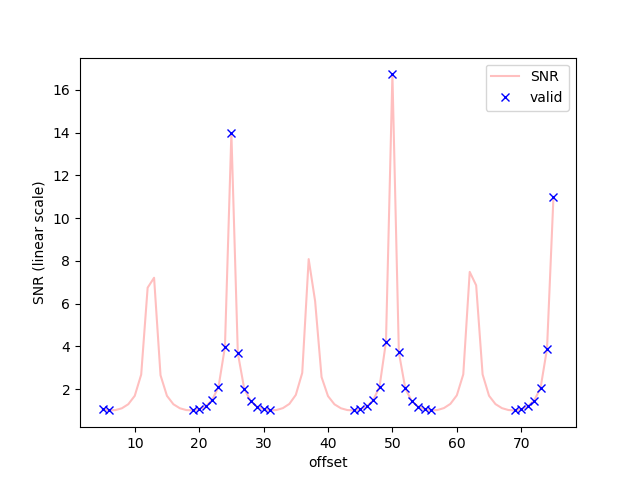

In [152]:
figure()
m = arange(len(SNRs))
plot(m[offset_min:],SNRs[offset_min:], "r", alpha=0.25, label="SNR")
n = arange(len(SNRs))
plot(n[valids],SNRs[valids], "bx", linewidth=1.0,label="valid")
xlabel("offset")
ylabel("SNR (linear scale)")
axis("tight")
legend(loc=0)

Long-Term Prediction
====================

In [131]:
class LTP(Quantizer):
    def __init__(self, order, **options):
        self.fir = FIR(a=r_[1.0, zeros(order)])
        self.history = zeros(order)
        self.ar = AR(a=zeros(order))
        self.order = order
        self.options = options
    def encode(self, frame):
        a = zeros_like(self.fir.a)
        a[0] = 1.0
        try:
            offset, gain = ltp_parameters(self.history, frame, **self.options)
            a[offset] = - gain
        except ValueError:
            offset, gain = 0, 0.0
        self.fir.a[:] = a 
        error = self.fir(frame)
        self.history = r_[self.history[len(frame):], frame]
        return (offset, gain), error
    def decode(self, data):
        (offset, gain), error = data
        a = zeros_like(self.ar.a)
        a[offset-1] = gain
        self.ar.a[:] = a
        return self.ar(error)

In [132]:
f_min = 50.0
f_max = 400.0
order_ltp = int(df/f_min)
print order_ltp
offset_min = int(df/f_max)
print offset_min

320
40


In [133]:
def ltp_error(data, T=0.005, order=order_ltp, **options):
    length = len(data)
    n = int(T * df) # number of samples for T s at the given sampling frequency.
    frames = audio.frames.split(data, n, pad=True)
    ltp = LTP(order=order, **options)
    error = zeros(n*len(frames))
    offset = zeros_like(error)
    gain = zeros_like(error)
    for i, frame in enumerate(frames):
        (offset_, gain_), error_frame = ltp.encode(frame)
        error[i*n:(i+1)*n] = error_frame
        offset[i*n:(i+1)*n] = ones_like(error_frame) * offset_
        gain[i*n:(i+1)*n] = ones_like(error_frame) * gain_
    error = error[:length]
    offset = offset[:length]
    gain = gain[:length]
    return error, offset, gain

<IPython.core.display.Javascript object>


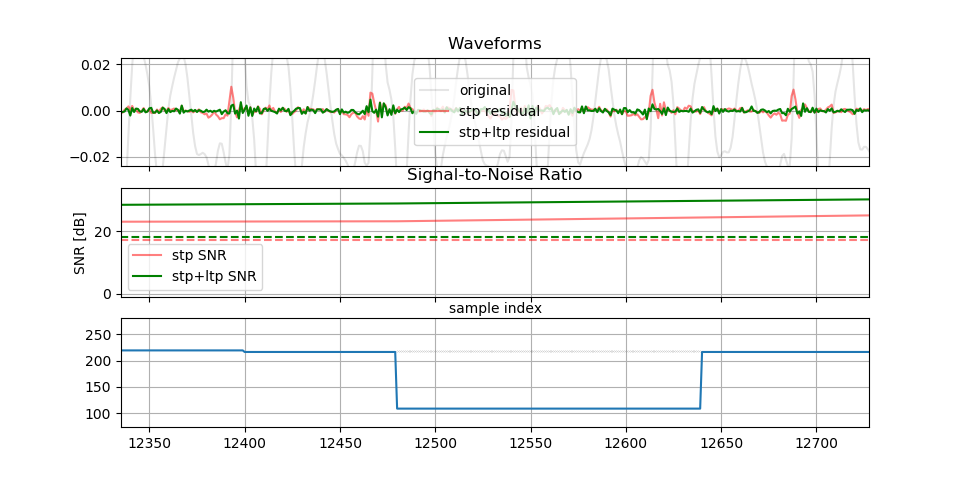

In [153]:
stp_error_ = stp_error(data)
ltp_error_, offset, gain = ltp_error(stp_error_, offset_min=offset_min, SNR_min=1.1, select=select(0.5))
stp_SNR2 = mean(data*data) / mean(stp_error_*stp_error_)
ltp_SNR2 = mean(data*data) / mean(ltp_error_*ltp_error_)

#figure()
#n = len(data)
#t = r_[0:n] / df

#plot(t,data, "k", alpha=0.1, label="audio"); axis("tight")
#plot(t, stp_error_, "r", label="STP error")
#plot(t, ltp_error_, "g", label="LTP error")
#legend(loc=0)

T = 20.0 / 1000 # 20 ms
n = int(df * T)
data_frames = audio.frames.split(data, n, pad=True)
stp_error_frames = audio.frames.split(stp_error_, n, pad=True)
ltp_error_frames = audio.frames.split(ltp_error_, n, pad=True)


fig, (ax1, ax2, ax3) = subplots(3,1, sharex=True)
stp_SNRs = [10.0 * log10(mean(d*d) / mean(e*e)) for d,e in zip(data_frames, stp_error_frames)]
ltp_SNRs = [10.0 * log10(mean(d*d) / mean(e*e)) for d,e in zip(data_frames, ltp_error_frames)]
ax1.plot(data, "k", alpha=0.1, label="original")
ax1.plot(stp_error_, "r", alpha=0.5, label="stp residual")
ax1.plot(ltp_error_, "g", alpha=1.0, label="stp+ltp residual")
ax1.set_title("Waveforms")
ax1.axis("tight")
ax1.legend()
ax1.grid()
ax2.plot(r_[0:len(stp_SNRs)] * n,  stp_SNRs, "r", alpha=0.5, label="stp SNR")
ax2.plot([0,len(data_frames)*n], [10*log10(stp_SNR2), 10*log10(stp_SNR2)], "r--", alpha=0.5)
ax2.plot(r_[0:len(ltp_SNRs)] * n,  ltp_SNRs, "g", label="stp+ltp SNR")
ax2.plot([0,len(data_frames)*n], [10*log10(ltp_SNR2), 10*log10(ltp_SNR2)], "g--")
ax2.set_xlabel("sample index")
ax2.set_ylabel("SNR [dB]")
ax2.set_title("Signal-to-Noise Ratio")
ax2.legend()
ax2.grid()
#n = len(data)
#t = r_[0:n] / df
ax3.plot(df / offset)
ax3.plot(2*df / offset, "k.", alpha=0.5, ms=0.25)
ax3.plot(3*df / offset, "k.", alpha=0.25, ms=0.25)
ax3.axis([0, len(data), 0, 400.0])
ax3.set_yticks(r_[0:400:50])
ax3.grid()

In [154]:
wave.write(ltp_error_, "voice-error-stp-ltp.wav", df=df)
display(Audio("voice.wav"))
display(Audio("voice-error-stp.wav"))
display(Audio("voice-error-stp-ltp.wav"))

<IPython.core.display.Javascript object>


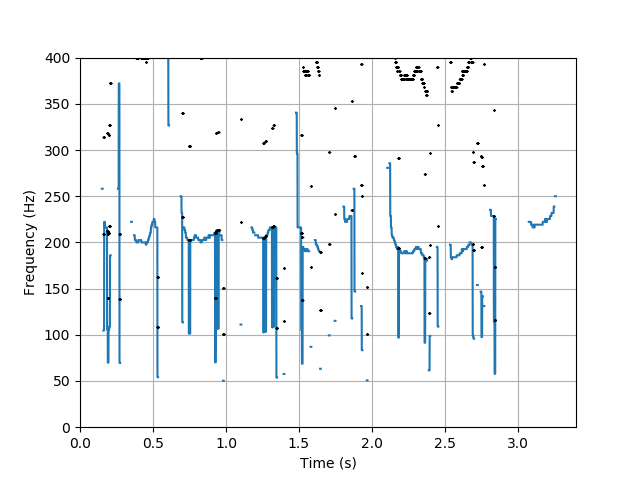

Text(0.5,0,u'Time (s)')

In [136]:
figure()
n = len(data)
t = r_[0:n] / df
plot(t, df / offset)
plot(t, 2*df / offset, "k.", alpha=0.5, ms=0.25)
plot(t, 3*df / offset, "k.", alpha=0.25, ms=0.25)

axis([t[0], t[-1], 00.0, 400.0])
grid()
ylabel("Frequency (Hz)")
xlabel("Time (s)")

<IPython.core.display.Javascript object>


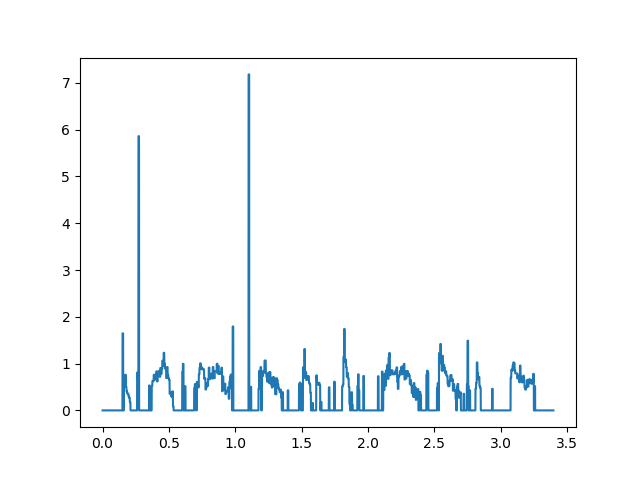

(-0.16991875, 3.56829375, -0.3590692309193679, 7.540453849306725)

In [56]:
figure()
n = len(data)
t = r_[0:n] / df
plot(t, gain)
axis("tight")